In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

from gzip import struct
import gzip
import os
from tqdm import tqdm

In [8]:
cap = cv2.VideoCapture(0)
while(cap.isOpened()):
    retval, frame = cap.read()
    cv2.imshow('Live', frame)
    if cv2.waitKey(5) >= 0:
        image = frame
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
def filter(X,H,channel_sum=False):
    h,w,c = X.shape
    p,q = H.shape
    if c!=3:
        X = np.transpose(X,(2,0,1))
        h,w,c = X.shape

    output = np.zeros((h+p-1,w+q-1,c))

    for channel in range(c):
        output[:,:,channel] = convolve2d(X[:,:,channel],H)

    if channel_sum:
        output = np.sum(output,axis=-1)

    return output
    

C:\Users\scatteredrain\AppData\Local\Temp\ipykernel_6572\1827149449.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  H = np.array(


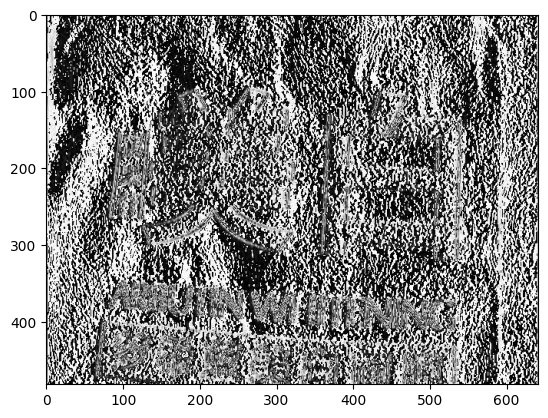

In [9]:
H = np.array(
    [
        [-1,0,1],
        [-1,0,1],
        [-1,0,1]
    ]
    ,dtype='uint8'
)

out = filter(image,H,channel_sum=True)
plt.imshow(np.uint8(out),cmap='gray')

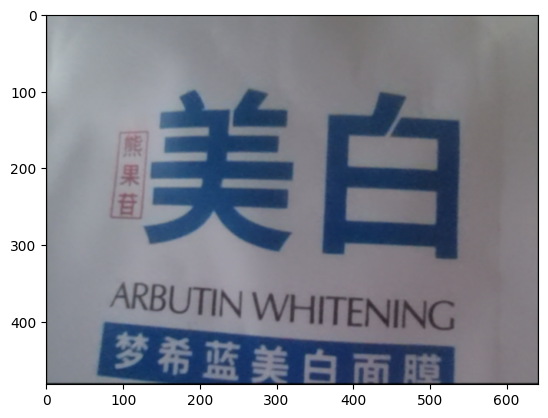

In [10]:
H = 1/16 * np.array(
    [
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ]

)

out = filter(image,H)
out = cv2.cvtColor(np.uint8(out),cv2.COLOR_RGB2BGR)
plt.imshow(out)

# MINIST Classification

In [ ]:
"""
下载MNIST数据集脚本
"""

import os
from pathlib import Path
import logging

import wget

logging.basicConfig(level=logging.INFO, format="%(message)s")


def download_minst(save_dir: str = None) -> bool:
    """下载MNIST数据集
    """
    save_dir = Path(save_dir)
    train_set_imgs_addr = save_dir / "train-images-idx3-ubyte.gz"
    train_set_labels_addr = save_dir / "train-labels-idx1-ubyte.gz"
    test_set_imgs_addr = save_dir / "t10k-images-idx3-ubyte.gz"
    test_set_labels_addr = save_dir / "t10k-labels-idx1-ubyte.gz"

    try:
        if not os.path.exists(train_set_imgs_addr):
            logging.info("下载train-images-idx3-ubyte.gz")
            filename = wget.download(url="http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", out=str(train_set_imgs_addr))
            logging.info("\tdone.")
        else:
            logging.info("train-images-idx3-ubyte.gz已经存在.")

        if not os.path.exists(train_set_labels_addr):
            logging.info("下载train-labels-idx1-ubyte.gz.")
            filename = wget.download(url="http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", out=str(train_set_labels_addr))
            logging.info("\tdone.")
        else:
            logging.info("train-labels-idx1-ubyte.gz已经存在.")

        if not os.path.exists(test_set_imgs_addr):
            logging.info("下载t10k-images-idx3-ubyte.gz.")
            filename = wget.download(url="http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", out=str(test_set_imgs_addr))
            logging.info("\tdone.")
        else:
            logging.info("t10k-images-idx3-ubyte.gz已经存在.")

        if not os.path.exists(test_set_labels_addr):
            logging.info("下载t10k-labels-idx1-ubyte.gz.")
            filename = wget.download(url="http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", out=str(test_set_labels_addr))
            logging.info("\tdone.")
        else:
            logging.info("t10k-labels-idx1-ubyte.gz已经存在.")
        
    except:
        return False
    
    return True

download_minst(save_dir="./")

In [2]:
def load_mnist_train(path, kind='train'): 

    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)
    #使用gzip打开文件
    with gzip.open(labels_path, 'rb') as lbpath:
	    #使用struct.unpack方法读取前两个数据，>代表高位在前，I代表32位整型。lbpath.read(8)表示一次从文件中读取8个字节
	    #这样读到的前两个数据分别是magic number和样本个数
        magic, n = struct.unpack('>II',lbpath.read(8))
        #使用np.fromstring读取剩下的数据，lbpath.read()表示读取所有的数据
        labels = np.frombuffer(lbpath.read(),dtype=np.uint8)
    with gzip.open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.frombuffer(imgpath.read(),dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [3]:
images_train, labels_train = load_mnist_train('E:\lecture\zuoye\Mine\gcsj\MNIST','train')
images_val, labels_val = load_mnist_train('E:\lecture\zuoye\Mine\gcsj\MNIST','t10k')

In [10]:
class Relu():
    def __init__(self):
        self.X = None

    def forward(self, X):
        self.X = X
        # print('X:',X)
        return np.where(X > 0, X, np.zeros_like(X))

    def backward(self, grad_pre):
        X = self.X
        return (X > 0).astype(np.float32) * grad_pre


# class Softmax():
#     def __init__(self):
#         self.X = None

#     def forward(self, X):
#         X_exp = np.exp(X)
#         denominator = np.sum(X_exp, axis=1, keepdims=True)
#         X = X_exp / (denominator + 1e-6)
#         self.X_exp = X_exp
#         return X

#     def backward(self, grad_s):
#         s = self.X_exp
#         tmp = np.matmul(np.expand_dims(grad_s, axis=1), np.diag(s))
#         tmp = np.squeeze(tmp, axis=1)
#         grad_p = -tmp + grad_s * s
#         return grad_p


class Sigmoid():
    def __init__(self):
        self.X_sig = None

    def forward(self, X):
        X = 1 / (1 + np.exp(-1*X))
        self.X_sig = X
        return X

    def backward(self, grad_s):
        s = self.X_sig
        # print(grad_s.shape,s.shape)
        grad_p = grad_s * s * (1-s)
        return grad_p

class LinearLayer():
    def __init__(self, C_input, C_output=3):
        self.C_input = C_input
        self.C_output = C_output
        self.X = None
        self.W = np.random.normal(loc=0, scale=1, size=[C_output, C_input]) / np.sqrt((C_input) / 2)  # He 初始化，有效提高 Relu 网络的性能

    def forward(self,X):
        self.X = X   #[in,1]
        return np.matmul(self.W,X)    #[out,in]@[in,1] -> [out,1]
    
    def backward(self,grad_pre,lr):
        grad_here = np.matmul(self.W.T,grad_pre)  #[in,out]@[out,1] -> [in,1]
        self.W -= lr*np.matmul(grad_pre,self.X.T)    #[out,1]@[1,in] -> [out,in]
        return grad_here
    
        # print('grad_pre',grad_pre.shape) #1,1
        # print('self.W.T',self.W.T.shape) #3,1
        # print('self.X',self.X.shape)  #1,3
class L2_loss():

    def forward(self,P,Y):
        en = P-Y # [1,1]
        loss = (en@en.T)**2 / 2

        return loss
    
    def backward(self,P,Y):
        return P-Y

class Fully_Connect_Network():
    def __init__(self, C_input, C_output):
        self.C_input = C_input
        self.C_output = C_output

        self.layer_in = LinearLayer(C_input,400)
        self.layer_hidden_1 = LinearLayer(400,200)
        self.layer_hidden_2 = LinearLayer(200,100)
        self.layer_out = LinearLayer(100,C_output)

        self.NonLinear_1 = Sigmoid()
        self.NonLinear_2 = Sigmoid()
        self.NonLinear_3 = Sigmoid()
        self.NonLinear_out = Sigmoid()
        self.loss = L2_loss()

    def forward(self,X):
        X = self.layer_in.forward(X)
        # print('1:',X.shape)
        X = self.NonLinear_1.forward(X) 

        X = self.layer_hidden_1.forward(X)
        # print('2:',X.shape)
        X = self.NonLinear_2.forward(X)     

        X = self.layer_hidden_2.forward(X)
        # print('3:',X.shape)
        X = self.NonLinear_3.forward(X)

        X = self.layer_out.forward(X)
        # print('4:',X.shape)
        X = self.NonLinear_out.forward(X)
        # print('Pred',X)
        
        return X
        # X = self.NonLinear_out.forward(X)


    def backward(self,P,Y,lr):
        
        loss = self.loss.forward(P,Y)
        grad = self.loss.backward(P,Y)
        # print('1:',grad.shape)
        
        grad = self.NonLinear_out.backward(grad)
        grad = self.layer_out.backward(grad,lr)
        # print('2:',grad.shape)
        grad = self.NonLinear_3.backward(grad)
        grad = self.layer_hidden_2.backward(grad,lr)
        # print('3:',grad.shape)
        grad = self.NonLinear_2.backward(grad)
        grad = self.layer_hidden_1.backward(grad,lr)
        # print('4:',grad.shape)
        grad = self.NonLinear_1.backward(grad)
        final_grad = self.layer_in.backward(grad,lr)

        return loss,final_grad


class Fully_Connect_Network2():
    def __init__(self,  channel_settings):
        self.layer_num = len(channel_settings)
        self.channel_settings = channel_settings

        self.linear_layers = []
        self.nonlinear_layers = []

        for (channel_in,channel_out) in channel_settings:
            self.linear_layers.append(LinearLayer(channel_in,channel_out))
            self.nonlinear_layers.append(Sigmoid())

        self.loss = L2_loss()


    def forward(self,X):

        for i in range(self.layer_num):
            X = self.linear_layers[i].forward(X)
            X = self.nonlinear_layers[i].forward(X)
        
        return X


    def backward(self,P,Y,lr):
        
        loss = self.loss.forward(P,Y)
        grad = self.loss.backward(P,Y)
        
        for i in range(self.layer_num-1,-1,-1):
            grad = self.nonlinear_layers[i].backward(grad)
            grad = self.linear_layers[i].backward(grad,lr)

        return loss, grad
    

    def save_weights(self,save_path='./FCN.npy'):
        state_dict = []
        for i in range(self.layer_num):
            state_dict.append(self.channel_settings[i])
            state_dict.append(self.linear_layers[i].W)
        np.save(save_path,np.array(state_dict))


    def load_weights(self,weights_file='./FCN.npy'):
        state_dict = np.load(weights_file,allow_pickle=True)
        for i in range(self.layer_num):
            channel_setting = state_dict[2*i]
            weights = state_dict[2*i+1]
            if channel_setting == self.channel_settings[i]:
                self.linear_layers[i].W = weights
            else:
                print('Weights no fit!!')
    

def normalize(dataset,mean,std):
    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min()) # 0~1
    return (dataset - mean)/std # -1~1

def dataloader(images,labels,batchsize=4):
    length,dim = images.shape
    images = images[:(length//batchsize*batchsize)]
    labels = labels[:(length//batchsize*batchsize)]
    images = images[np.newaxis,:].reshape(-1,batchsize,dim)
    labels = labels[np.newaxis,:].reshape(-1,batchsize,1)
    return images,labels

def train_epoch(model,images,labels,lr=1e-4,batchsize=4):

    losses = []
    grads = []
    # print(dataset[:10])
    images = normalize(images,0.5,0.5)
    images,labels = dataloader(images,labels,batchsize=batchsize)
    for image,label in zip(images,labels):
        # print(i)
        X = image.transpose(1,0)
        Y = np.zeros((10,1))
        Y[label] = 1
        # forward
        Pred = model.forward(X)
        # backward
        loss, final_grad = model.backward(Pred,Y,lr)
        losses.append(loss)
        grads.append(final_grad)
        # print('label:',Y)
        # if i%500 ==0:
        #     tqdm.write(f'{i},pred:{Pred},label:{Y}')
    return losses,grads

# model = Fully_Connect_Network(784,10)
model = Fully_Connect_Network2([(784,400),(400,200),(200,100),(100,10)])
offsetx = 5
offsety = -2
lr = 0.001
losses = []
grads = []

100%|███████████████████████████████████████████| 30/30 [23:06<00:00, 46.20s/it]


Text(0, 0.5, 'loss value')

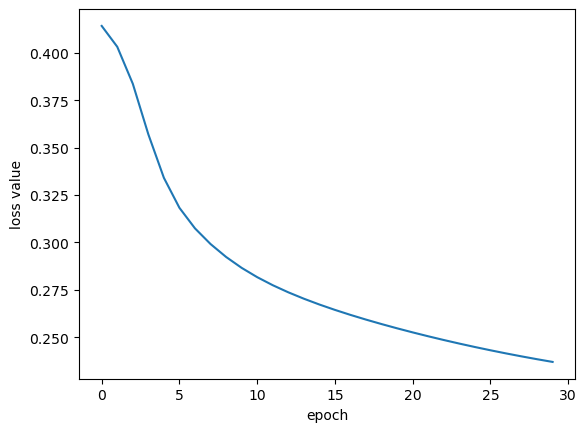

In [11]:
# for epoch in tqdm(range(1000),ncols=10):
batchsize = 4
for epoch in tqdm(range(30),ncols=80):
    loss, grad = train_epoch(model,images_train,labels_train,lr,batchsize)
    losses.append(np.mean(loss))
    grads.append(np.mean(grad))
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss value')

In [12]:
model.save_weights()

C:\Users\scatteredrain\AppData\Local\Temp\ipykernel_27388\3341898508.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(save_path,np.array(state_dict))


In [18]:
model_trained = Fully_Connect_Network2([(784,400),(400,200),(200,100),(100,10)])
model_trained.load_weights('./FCN.npy')

实际类别:        1 |       0 |       2 |       9 |       9 |       3 |       6 |       8 |       7 |       7
预测类别:        1 |       0 |       2 |       9 |       9 |       3 |       6 |       8 |       7 |       7
----------------------------------------------------------------------------------------------------------------
判断正确？       √ |       √ |       √ |       √ |       √ |       √ |       √ |       √ |       √ |       √


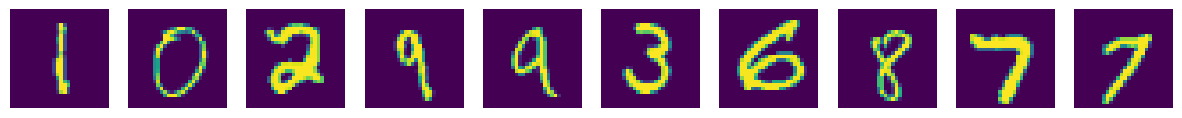

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 2.0)
test = normalize(images_val,0.5,0.5)
test_Num = 10
idxs = np.random.randint(0,len(test),size=test_Num)
predict_labels = []
true_labels = []
for i,idx in enumerate(idxs):
    plt.subplot(1,test_Num,i+1)
    # plt.axes('off')
    image = test[idx]
    label = labels_val[idx]
    predict = model_trained.forward(image.reshape(784,1))
    predict_lable = np.argmax(predict)
    predict_labels.append(predict_lable)
    true_labels.append(label)
    plt.imshow(image.reshape(28,28))
    plt.axis('off')

judge = []
for j in range(test_Num):
    if true_labels[j] == predict_labels[j]:
        judge.append('√')
    else:
        judge.append('❌')

print("实际类别: ", " | ".join("%7s"%true_labels[j] for j in range(test_Num)))
print("预测类别: ", " | ".join("%7s"%predict_labels[j] for j in range(test_Num)))
print("--"*56)
print("判断正确？", " | ".join("%7s"%judge[j] for j in range(test_Num)))

In [19]:
T, F = 0,0
test = normalize(images_val,0.5,0.5)

for image,label in zip(test,labels_val):
    predict = model_trained.forward(image.reshape(784,1))
    P = np.argmax(predict)
    if P == label: T+=1
    else: F+=1

print('average accuracy:',T/(T+F))

average accuracy: 0.9107
